## Importación de librerías

In [1]:
from skimage import morphology as mo
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.morphology import skeletonize , medial_axis
from skimage.util import invert
from scipy import ndimage as ndi
import cv2 as cv
import skimage as ski
from scipy.ndimage import uniform_filter
import os
import re
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from scipy.optimize import differential_evolution


2025-03-13 18:51:51.309970: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 18:51:51.386583: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 18:51:51.450770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741891911.500417   23321 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741891911.518200   23321 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741891911.607898   23321 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Algoritmos de thresholding

In [289]:
def ThSauvola(I,w = 20 , k=0.05, R = 255):
    I = I.astype(np.float32)
    
    mu = uniform_filter(I, w, mode='reflect')
    
    mu_sq = uniform_filter(I**2, w, mode='reflect')
    s = np.sqrt(mu_sq - mu**2)

    Th = mu * (1 + k * ((s / R) - 1))
    return (I > Th).astype(np.uint8)*255, Th

def ThNiblack(I, w=20, k=-0.7):
    I = I.astype(np.float32)
    mu = uniform_filter(I, w, mode='reflect')
    mu_sq = uniform_filter(I**2, w, mode='reflect')
    sigma = np.sqrt(mu_sq - mu**2)
    Th = mu + k * sigma
    return (I > Th).astype(np.uint8) * 255, Th

def ThWolfJolion(I, w=25, k=0.05, R=255):
    I = I.astype(np.float32)
    mu = uniform_filter(I, w, mode='reflect')
    mu_sq = uniform_filter(I**2, w, mode='reflect')
    sigma = np.sqrt(mu_sq - mu**2)
    min_I = np.min(I)
    Th = (1 - k) * mu + k * ((mu - min_I) / (R - min_I)) * sigma
    return (I > Th).astype(np.uint8) * 255, Th

def ThBernsen(I, w=10, Cmin=1):
    half_w = w // 2
    T = np.zeros_like(I, dtype=np.float32)
    for i in range(int(half_w), int(I.shape[0] - half_w)):
        for j in range(int(half_w), int(I.shape[1] - half_w)):
            local_region = I[int(i - half_w):int(i + half_w + 1), int(j - half_w):int(j + half_w + 1)]
            Imax, Imin = np.max(local_region), np.min(local_region)
            if (Imax - Imin) < Cmin:
                T[i, j] = 128
            else:
                T[i, j] = (Imax + Imin) / 2
    return (I > T).astype(np.uint8) * 255, 0

def ThPhansalkar(I, w=15, k=0.04, R=128, p=3, q=3):
    I = I.astype(np.float32)
    mu = uniform_filter(I, w, mode='reflect')
    mu_sq = uniform_filter(I**2, w, mode='reflect')
    sigma = np.sqrt(mu_sq - mu**2)
    Th = mu * (1 + p * np.exp(-q * mu) + k * ((sigma / R) - 1))
    return (I > Th).astype(np.uint8) * 255, Th

## Preprocesamiento de la imagen para quitar los negros del microscopio

In [141]:
def preprocess(image):
    # elegir el limite para el pre procesamiento
    if ( np.percentile(image, 3) / np.percentile(image, 50)<=0.4*np.percentile(image, 50)/100):
        limite = np.percentile(image, 3)
    elif ( np.percentile(image, 2) / np.percentile(image, 50)<=0.4*np.percentile(image, 50)/100):
        limite = np.percentile(image, 2)
    
    else: 
        limite = np.percentile(image, 1)
    mask = (image <=  limite).astype(np.uint8) * 255
    
    kernel = np.ones((5, 5), np.uint8)
    mask_refined = cv2.dilate(mask, kernel, iterations=1)
    
    inpaint_radius = 100
    restored = cv2.inpaint(image, mask_refined, inpaintRadius=inpaint_radius, flags=cv2.INPAINT_NS)
    
    restored = cv2.GaussianBlur(restored, (5, 5), 0)
    return restored

## Post procesamiento de la imagen para eliminar el ruido de la imagen

In [311]:
def postprocess(image):
    kernel = np.ones((5, 5), np.uint8)
    image_opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    image_closed = cv2.morphologyEx(image_opened, cv2.MORPH_CLOSE, kernel)
    return image_closed

## Mostrar resultados y realizar el proceso

In [304]:
def display_results(I, methods, fileName):
    results = {}
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 3, 1)
    has_gt = True
    try:
        plt.title(f"Manual Filtered Image")
        filtered = plt.imread(f'{os.curdir}/database/{fileName.split(".")[0]+"_gt."+fileName.split(".")[1]}')
        plt.imshow(filtered, cmap='gray')
        results['manual_filtered_image'] = filtered
    except:
        plt.title(f"Original Image")
        plt.imshow(I, cmap='gray')
        has_gt = False

    for i, (name, method) in enumerate(methods.items()):
        plt.subplot(3, 3, i + 2)
        plt.title(name)
        copy_I = I
        copy_I = preprocess(copy_I)
        I2, th = method(copy_I)
        I2 = postprocess(255-I2)
        if has_gt:
            results[method.__name__] = I2
        plt.imshow(I2, cmap='gray')
    
    plt.tight_layout()
    plt.show()
    return results

In [278]:
# Define thresholding methods
methods = {
    "Sauvola": ThSauvola,
    "Niblack": ThNiblack,
    "Wolf-Jolion": ThWolfJolion,
    "Bernsen": ThBernsen,
    "Phansalkar": ThPhansalkar,
}

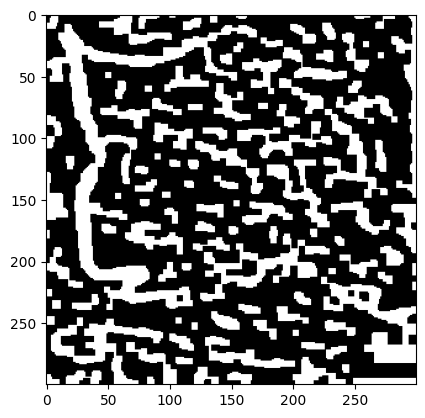

In [338]:
I = plt.imread('database/8.pgm')
I = preprocess(I)
I2, th = ThPhansalkar(I, w=7, k=0.005, R=128, p=3, q=3)
I2_combined = postprocess(255 - I2)

# Display the result
plt.imshow(I2_combined, cmap='gray')
plt.show()
# Display results
# display_results(I, methods, 'database/8.pgm')

8.pgm


/tmp/ipykernel_23321/1532314292.py:39: RuntimeWarning: overflow encountered in scalar add
  T[i, j] = (Imax + Imin) / 2


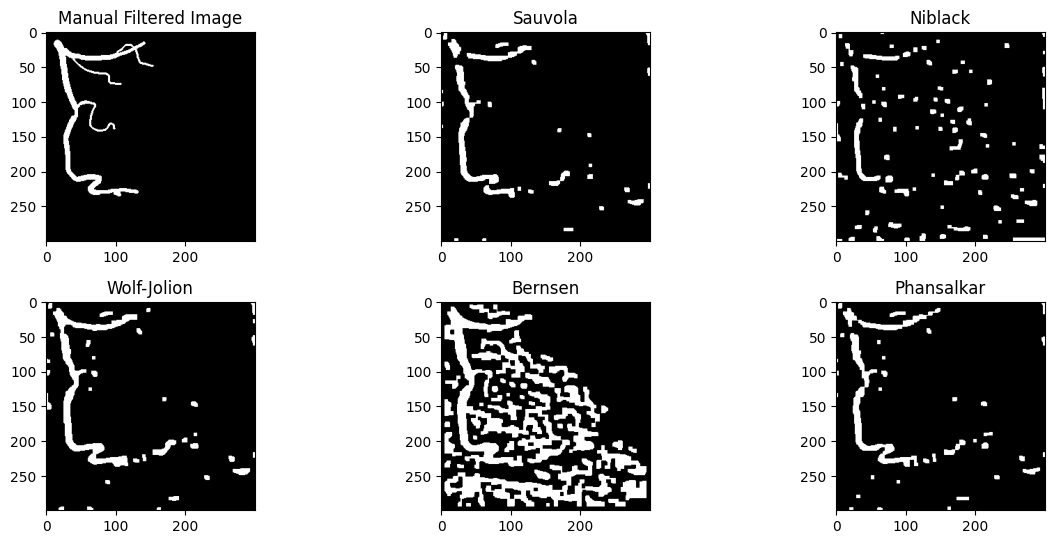

17.pgm


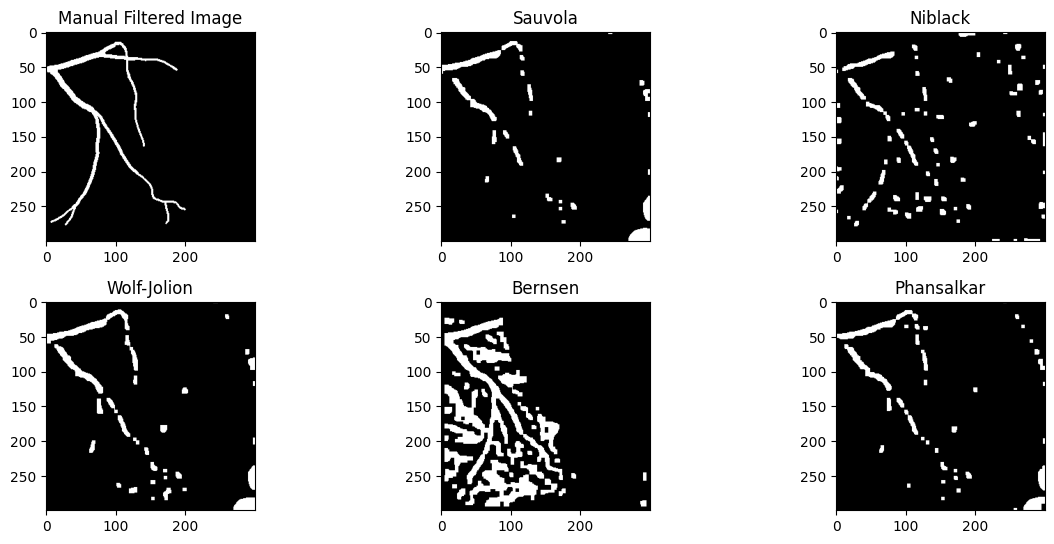

20.pgm


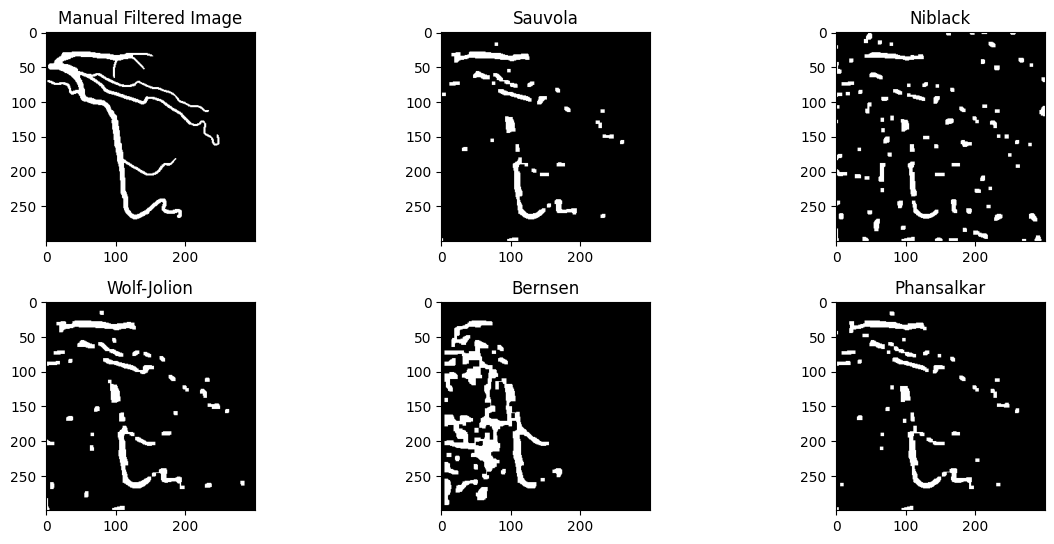

12.pgm


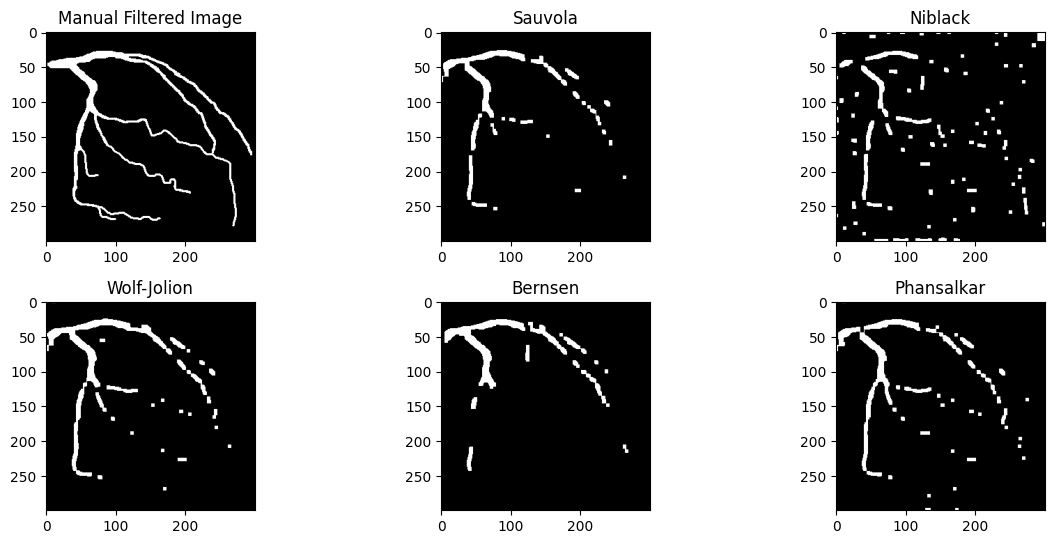

19.pgm


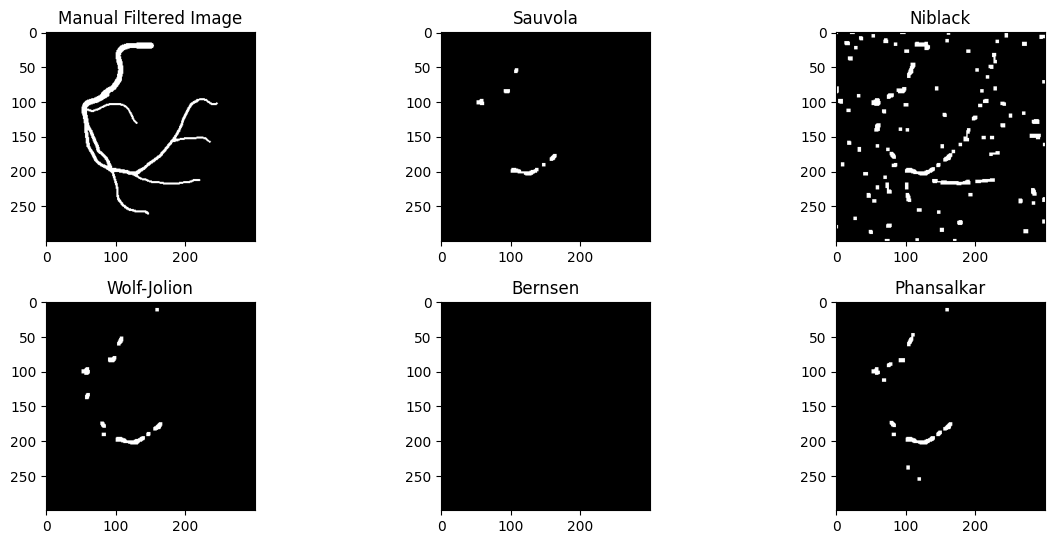

9.pgm


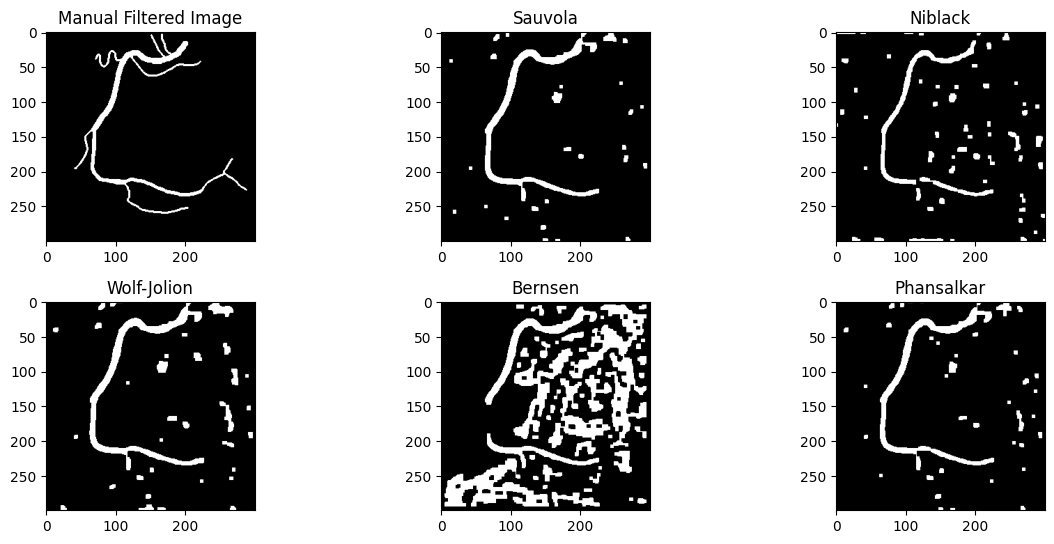

18.pgm


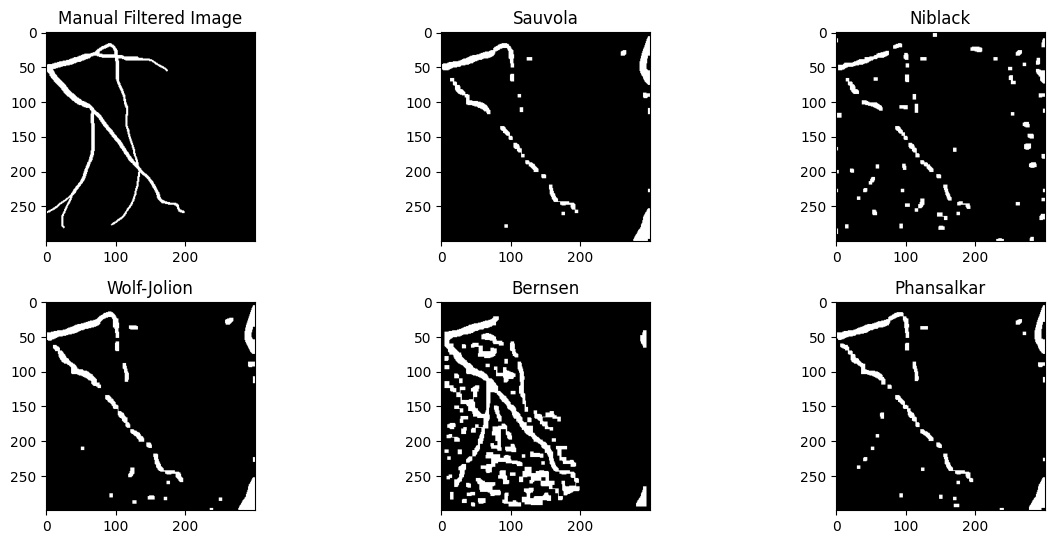

6.pgm


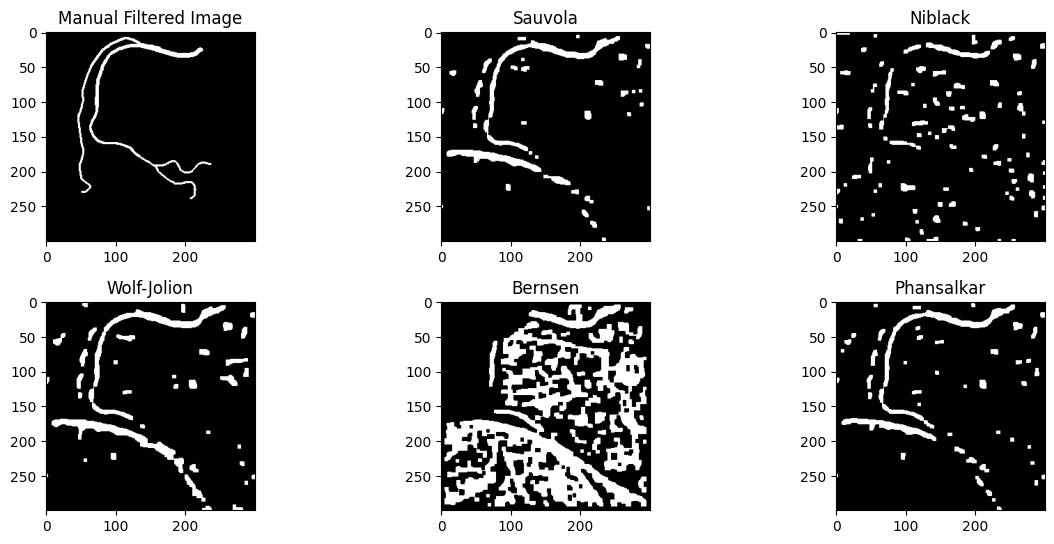

3.pgm


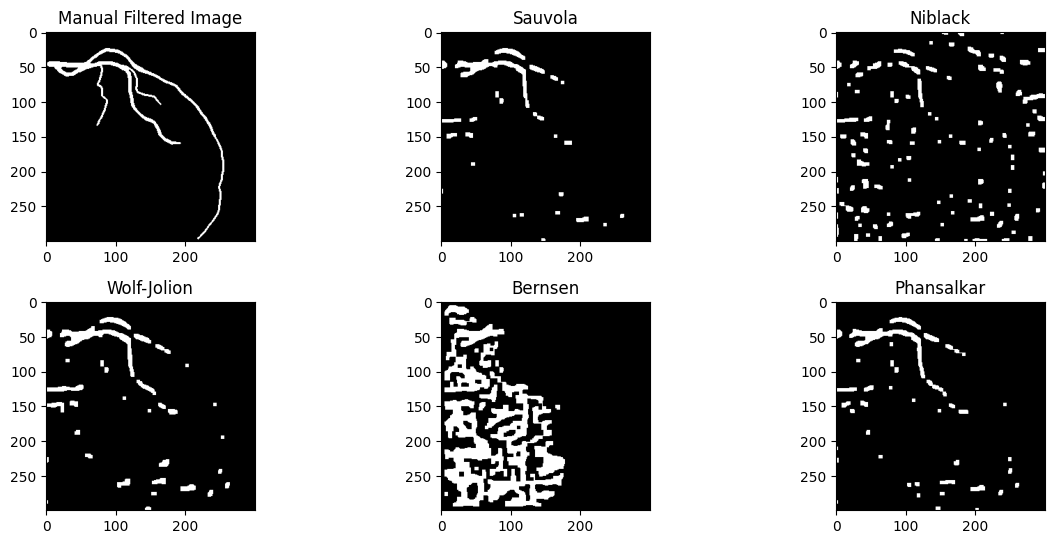

11.pgm


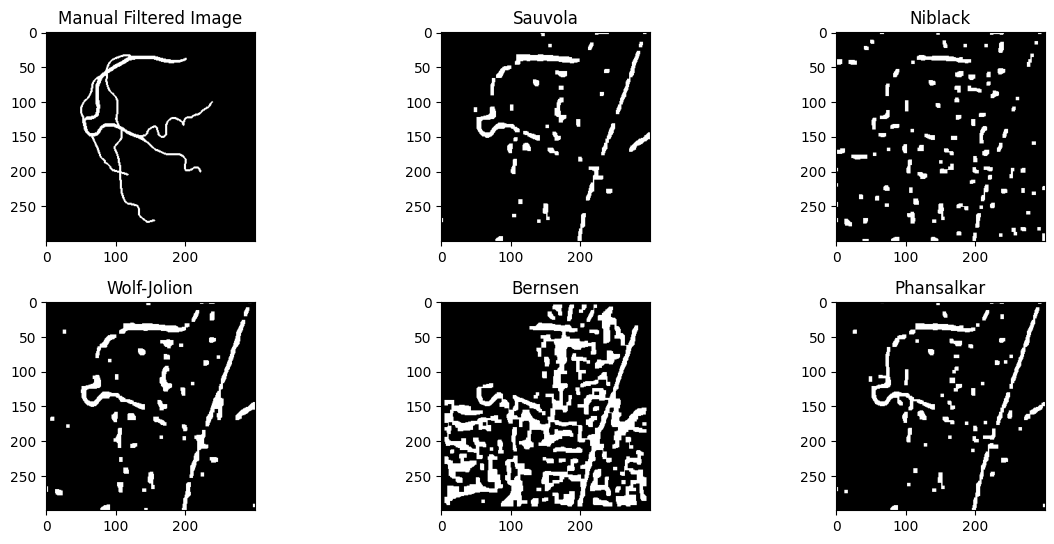

13.pgm


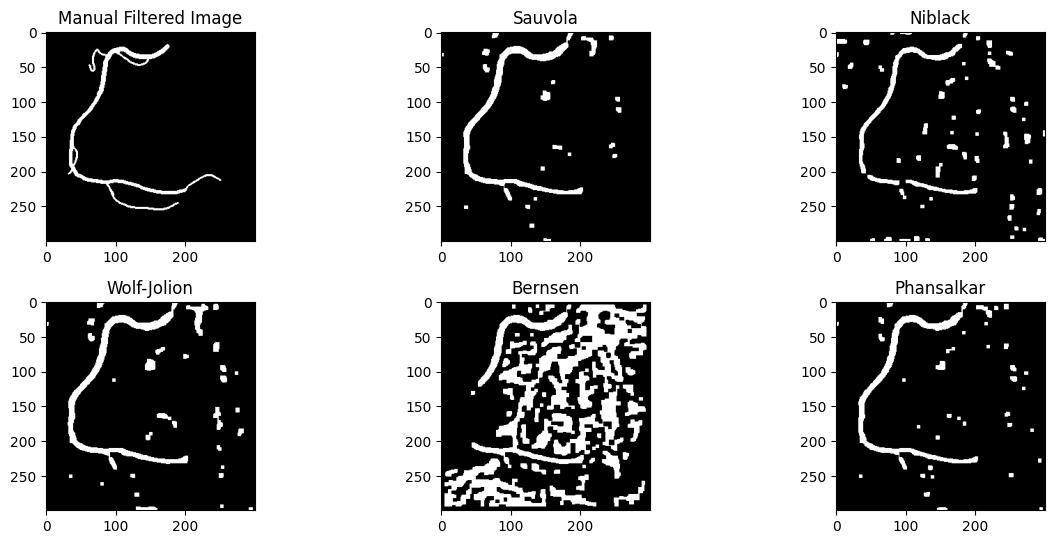

4.pgm


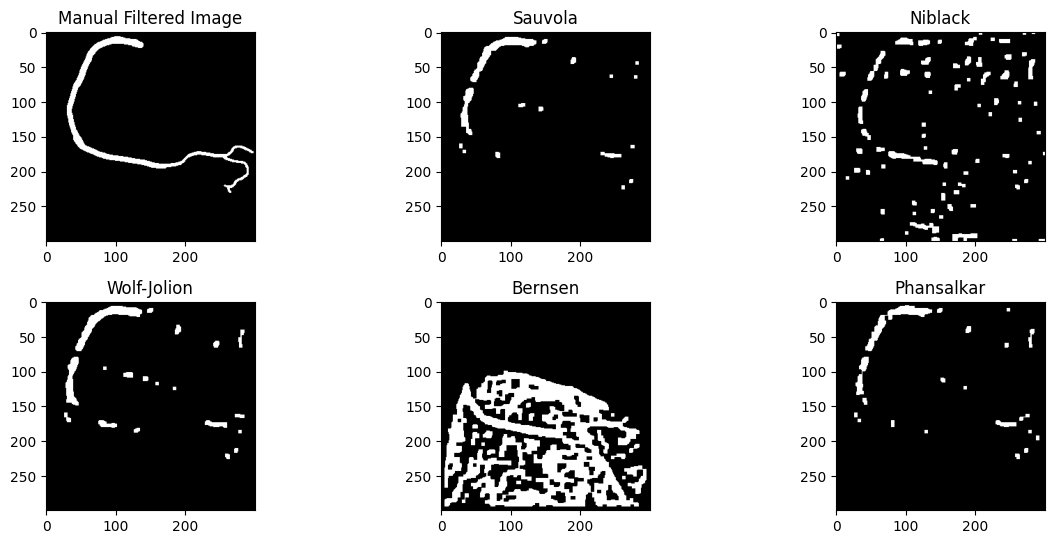

1.pgm


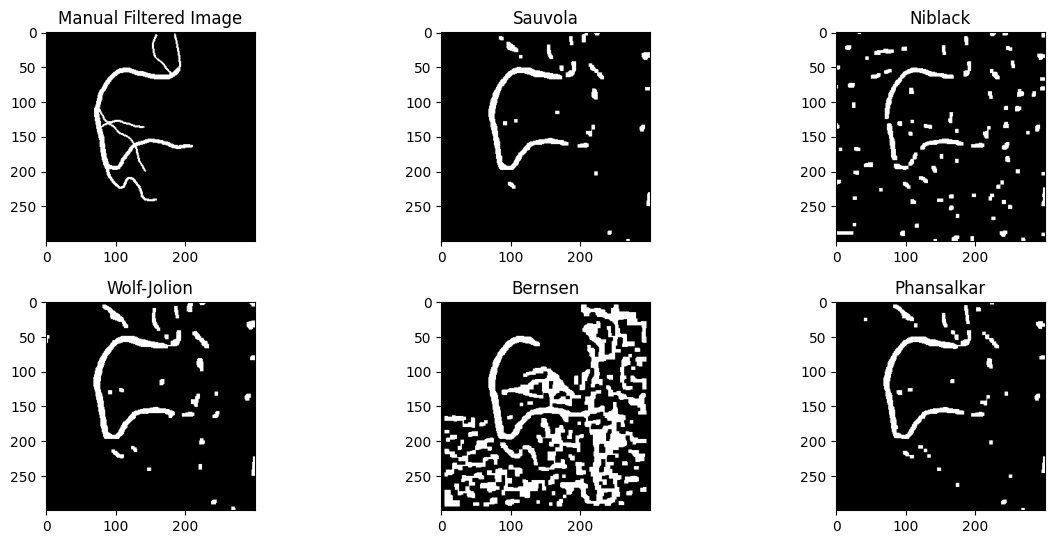

7.pgm


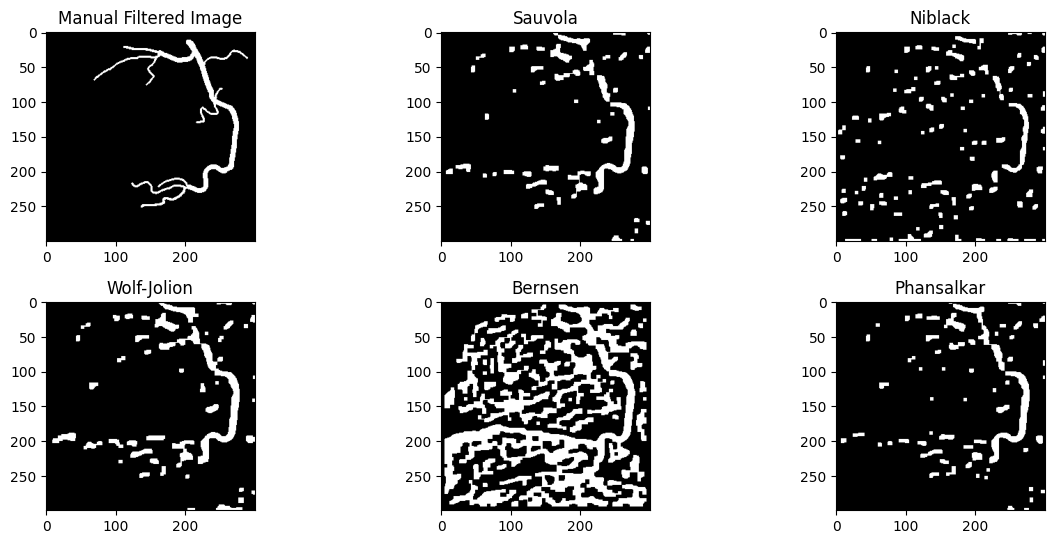

15.pgm


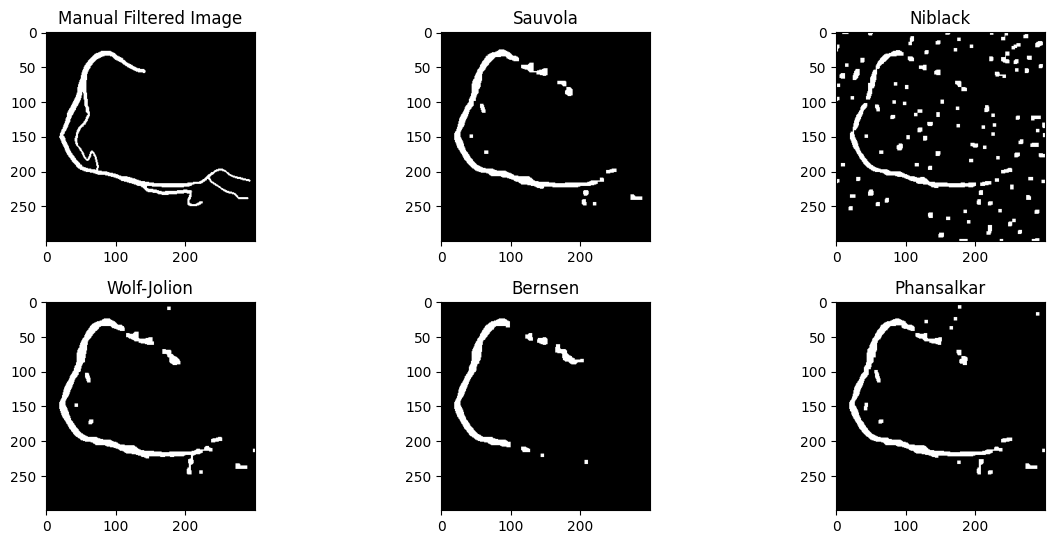

14.pgm


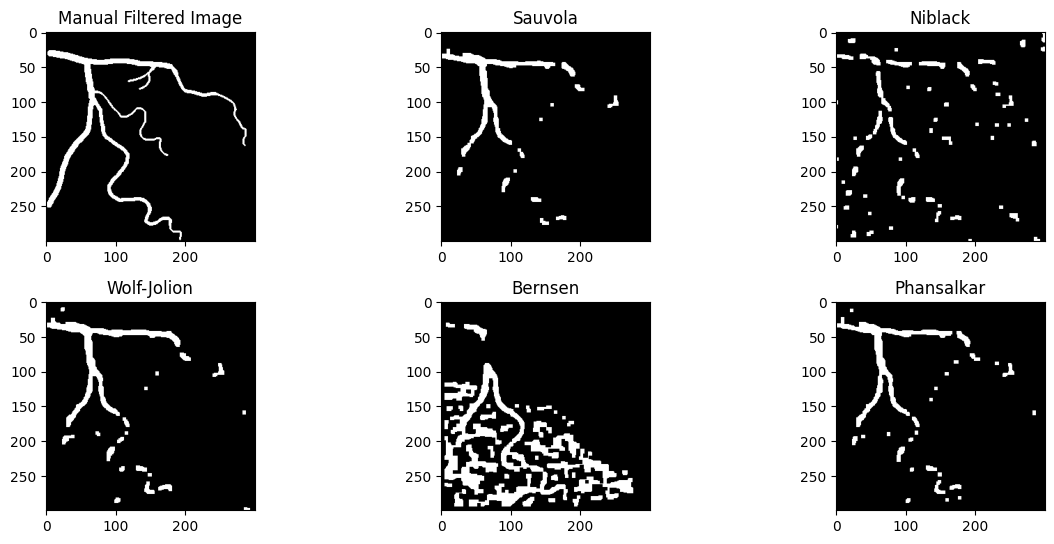

16.pgm


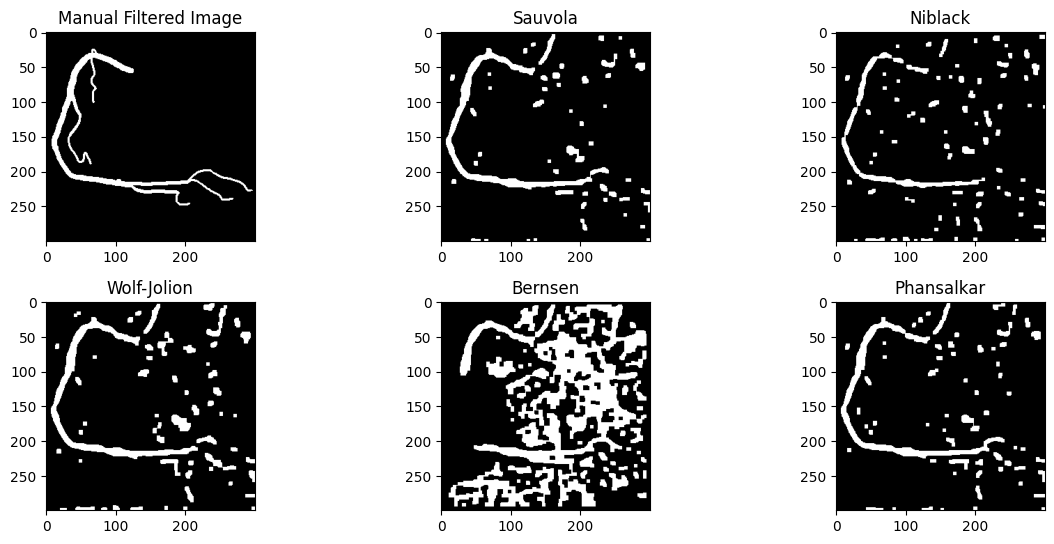

10.pgm


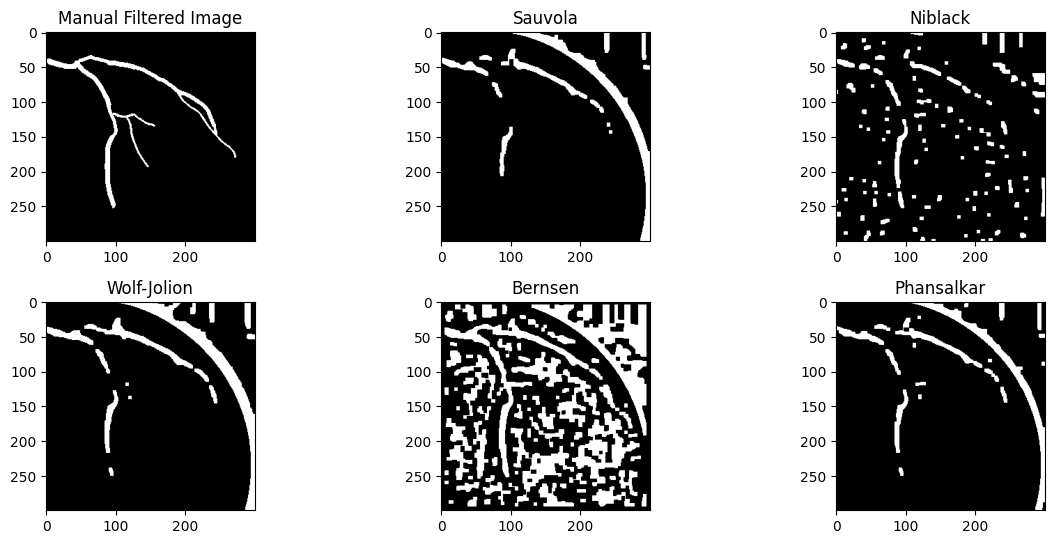

2.pgm


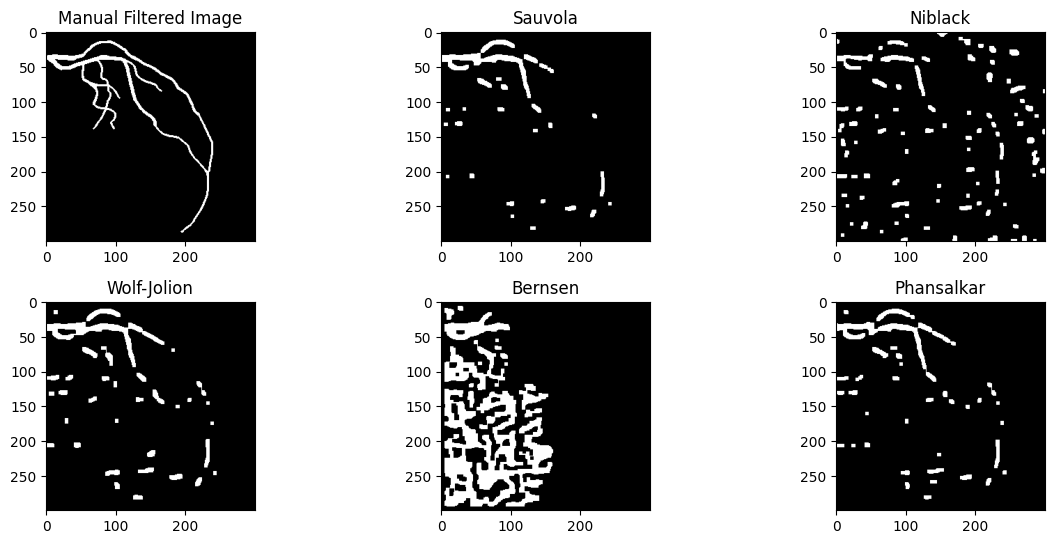

5.pgm


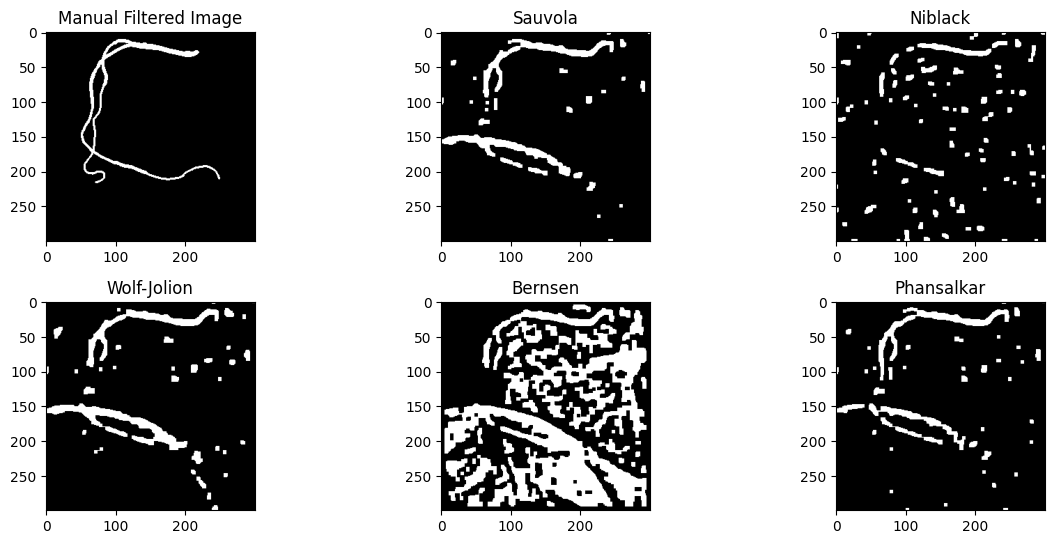

8.pgm  \
manual_filtered_image  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThSauvola              [[0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0...   
ThNiblack              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThWolfJolion           [[0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0...   
ThBernsen              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThPhansalkar           [[0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0...   

                                                                  17.pgm  \
manual_filtered_image  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThSauvola              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThNiblack              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThWolfJolion           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThBernsen              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThPhansalkar           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                                  20.pgm  \
manual_filtered_image  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThSauvola              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThNiblack              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThWolfJolion           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThBernsen              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThPhansalkar           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                                  12.pgm  \
manual_filtered_image  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThSauvola              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThNiblack              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 25...   
ThWolfJolion           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 25...   
ThBernsen              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThPhansalkar           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 25...   

                                                                  19.pgm  \
manual_filtered_image  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThSauvola              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThNiblack              [[255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThWolfJolion           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThBernsen              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThPhansalkar           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                                   9.pgm  \
manual_filtered_image  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThSauvola              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThNiblack              [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   
ThWolfJolion           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThBernsen              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThPhansalkar           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                                  18.pgm  \
manual_filtered_image  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThSauvola              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThNiblack              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThWolfJolion           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThBernsen              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThPhansalkar           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                                   6.pgm  \
manual_filtered_image  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThSauvola              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
ThNiblack              [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   
ThWolfJolion           [[0, 0, 0

In [305]:
results = {}
for file in os.listdir(f'{os.curdir}/database'):
    if not re.search(r"(_gt|.ipynb)", file):
        print(file)
        I = plt.imread(f'{os.curdir}/database/{file}')
        # Display results
        results[file] = display_results(I, methods, file)

data = pd.DataFrame(data = results)
data

In [306]:
def pivot_table(dataframe):
    newDf = pd.DataFrame(index=dataframe.columns, columns=dataframe.index)
    for index in dataframe.index:
        newDf[index] = dataframe.loc[index]
    
    return newDf

In [307]:
pivoted_data = pivot_table(data)
pivoted_data

manual_filtered_image  \
8.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
17.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
20.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
12.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
19.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
9.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
18.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
6.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
11.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
13.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
7.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
15.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
14.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
16.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
10.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
5.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                ThSauvola  \
8.pgm   [[0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0...   
17.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
20.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
12.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
19.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
9.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
18.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
6.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
11.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
13.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
7.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
15.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
14.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
16.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
10.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
5.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                ThNiblack  \
8.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
17.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
20.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
12.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 25...   
19.pgm  [[255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
9.pgm   [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   
18.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
6.pgm   [[255, 255, 255, 255, 255, 255, 255, 255, 255,...   
3.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
11.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
13.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4.pgm   [[255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0...   
1.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
7.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
15.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255, 25...   
14.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
16.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
10.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2.pgm   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
5.pgm   [[255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                             ThWolfJolion  \
8.pgm   [[0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0...   
17.pgm  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
20.pgm 

## Cálculo de métricas

In [308]:
def calculate_metrics(dataframe):
    metrics = pd.DataFrame(columns = ['image', 'threshold', 'accuracy', 'recall', 'specificity', 'precision', 'f1'])
    metodos = ["manual","Sauvola","Niblack","Wolf-Jolion","Bernsen","Phansalkar","Adaptive Mean","Contrast Adaptive","Gaussian Weighted"]
    
    for index in dataframe.index:
        row = dataframe.loc[index]
        manual_filtered_image = row[0]  # Assuming the first column is the manually thresholded image
        
        # Loop through methods (columns from 1 to the last column)
        for i in range(1, len(row)):
            method = metodos[i]  # Get the method name
            image_method = row[i]
            
            TP = np.sum((image_method == 255) & (manual_filtered_image == 255)) # True positives
            FP = np.sum((image_method == 255) & (manual_filtered_image == 0)) # False positives
            FN = np.sum((image_method == 0) & (manual_filtered_image == 255)) # False negatives
            TN = np.sum((image_method == 0) & (manual_filtered_image == 0)) # True negatives
            accuracy = (TP + TN) / (TP + TN + FP + FN)
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            specificity = TN / (TN + FP)
            f1 = 2 * precision * recall / (precision + recall)            
            # Create a new row with calculated metrics
            new_row = pd.DataFrame([[index, method, accuracy, recall, specificity, precision, f1]], 
                                   columns=metrics.columns)
            
            # Append the new row to the metrics DataFrame
            metrics = pd.concat([metrics, new_row], ignore_index=True)
    
    return metrics

In [309]:
metrics = calculate_metrics(pivoted_data)
metrics

/tmp/ipykernel_23321/990926197.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  manual_filtered_image = row[0]  # Assuming the first column is the manually thresholded image
/tmp/ipykernel_23321/990926197.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_method = row[i]
/tmp/ipykernel_23321/990926197.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics

image    threshold  accuracy    recall  specificity  precision        f1
0   8.pgm      Sauvola  0.966111  0.693737     0.979441   0.622835  0.656377
1   8.pgm      Niblack  0.931133  0.497976     0.952332   0.338295  0.402890
2   8.pgm  Wolf-Jolion  0.957656  0.796856     0.965525   0.530774  0.637151
3   8.pgm      Bernsen  0.738167  0.881638     0.731145   0.138289  0.239078
4   8.pgm   Phansalkar  0.960478  0.734937     0.971515   0.558047  0.634392
..    ...          ...       ...       ...          ...        ...       ...
95  5.pgm      Sauvola  0.945300  0.695545     0.954672   0.365397  0.479103
96  5.pgm      Niblack  0.932233  0.461137     0.949911   0.256757  0.329854
97  5.pgm  Wolf-Jolion  0.929700  0.709677     0.937956   0.300312  0.422033
98  5.pgm      Bernsen  0.619756  0.705069     0.616554   0.064544  0.118262
99  5.pgm   Phansalkar  0.945700  0.717051     0.954280   0.370476  0.488540

[100 rows x 7 columns]

In [310]:
metrics[["threshold", "accuracy", "recall", "specificity", "precision", "f1"]].groupby(by=["threshold"]).mean()

accuracy    recall  specificity  precision        f1
threshold                                                        
Bernsen      0.771927  0.570356     0.783761   0.184700  0.233982
Niblack      0.930917  0.475836     0.955067   0.358312  0.400277
Phansalkar   0.950889  0.602807     0.969441   0.533656  0.539781
Sauvola      0.952647  0.559804     0.973602   0.562171  0.528351
Wolf-Jolion  0.943486  0.623901     0.960532   0.490769  0.517434

## Desarrollo de red neuronal para cálculo de hiperparámetros

In [6]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 1.5 MB/s eta 0:00:0000:0100:10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 2.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 2.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 2.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 2.2 MB/s eta 0:00:00a 0:00:01


In [ ]:
def calculate_f1_score(I2, manual_filtered_image):
    TP = np.sum((I2 == 255) & (manual_filtered_image == 255))  # True positives
    FP = np.sum((I2 == 255) & (manual_filtered_image == 0))    # False positives
    FN = np.sum((I2 == 0) & (manual_filtered_image == 255))    # False negatives
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return f1
    
# Función para generar datos de entrenamiento
def generate_training_data(I, manual_filtered_image, method, param_ranges, num_samples=10):
    X = []
    y = []
    for _ in range(num_samples):
        params = {key: np.random.uniform(low, high) for key, (low, high) in param_ranges.items()}
        I2, _ = method(I, **params)
        f1 = calculate_f1_score(I2, manual_filtered_image)
        X.append(list(params.values()))
        y.append(f1)
    return np.array(X), np.array(y)

# Función para construir la red neuronal
def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(1)  # Salida: F1 score
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Función para optimizar los parámetros usando la red neuronal
def optimize_parameters_nn(model, param_ranges):
    def predict_f1(params):
        params = np.array(params).reshape(1, -1)
        return -model.predict(params)[0]  # Negativo porque queremos maximizar

    bounds = [param_ranges[key] for key in param_ranges.keys()]
    result = differential_evolution(predict_f1, bounds)
    optimized_params = {key: result.x[i] for i, key in enumerate(param_ranges.keys())}
    return optimized_params

# Función principal para procesar todas las imágenes
def process_images_nn(directory):
    results = {}
    for file in os.listdir(directory):
        if not re.search(r"(_gt|.ipynb)", file):  # Ignorar archivos _gt y .ipynb
            I = plt.imread(f'{directory}/{file}')
            try:
                # Cargar la imagen manualmente filtrada (ground truth)
                manual_filtered_image = plt.imread(f'{directory}/{file.split(".")[0]}_gt.{file.split(".")[1]}')
            except FileNotFoundError:
                print(f"No ground truth found for {file}, skipping...")
                continue

            # Diccionario para almacenar los parámetros optimizados para cada método
            optimized_params = {}

            # Aplicar optimización basada en red neuronal a cada método
            for method_name, method in methods.items():
                # Rangos de parámetros (pueden variar según el método)
                if method_name == "Sauvola":
                    param_ranges = {'w': (5, 20), 'k': (0.01, 0.05), 'R': (100, 150)}
                elif method_name == "Niblack":
                    param_ranges = {'w': (30, 90), 'k': (-1.0, 0.0)}
                elif method_name == "Wolf-Jolion":
                    param_ranges = {'w': (5, 20), 'k': (0.01, 0.05), 'R': (100, 150)}
                elif method_name == "Bernsen":
                    param_ranges = {'w': (3, 15), 'Cmin': (5, 20)}
                elif method_name == "Phansalkar":
                    param_ranges = {'w': (10, 20), 'k': (0.01, 0.05), 'R': (100, 150), 'p': (1, 3), 'q': (5, 15)}
                # elif method_name == "Adaptive Mean":
                #     param_ranges = {'w': (3, 15)}
                # elif method_name == "Contrast Adaptive":
                #     param_ranges = {'w': (5, 15), 'Cmin': (5, 20)}

                # Generar datos de entrenamiento
                X, y = generate_training_data(I, manual_filtered_image, method, param_ranges, num_samples=1000)

                # Dividir los datos en entrenamiento y validación
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

                # Construir y entrenar el modelo
                model = build_model(X_train.shape[1])
                model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

                # Optimizar los parámetros usando la red neuronal
                params_optimized = optimize_parameters_nn(model, param_ranges)
                optimized_params[method_name] = params_optimized

            # Guardar los resultados para esta imagen
            results[file] = optimized_params

    return results

# Directorio de la base de datos
database_dir = f'{os.curdir}/database'

# Procesar todas las imágenes
results_nn = process_images_nn(database_dir)

# Mostrar los resultados
for file, params in results_nn.items():
    print(f"Image: {file}")
    for method, optimized_params in params.items():
        print(f"  {method}: {optimized_params}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

/tmp/ipykernel_97171/3150844918.py:42: RuntimeWarning: overflow encountered in scalar add
  T[i, j] = (Imax + Imin) / 2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

/tmp/ipykernel_97171/3150844918.py:50: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(mu_sq - mu**2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━